# Fed-BioMed Researcher to train a model on a CSV dataset

In [ ]:
from pathlib import Path

from dotenv import dotenv_values

# settings
ML_PROBLEM_TYPE = "regression"  # "classification", "regression"
SETUP_TYPE = "mega"  # "mega", "silo", "fed"
DATASETS = ["adni", "ppmi", "qpn"]
I_SPLIT = 0
RNG_SEED = 3791
NN_LAYER_SIZE = 1024
FEDBIOMED_ROUNDS = 1

ENV_VARS = dotenv_values("../.env")
DPATH_DATA = Path(ENV_VARS["DPATH_FL_DATA"])
DPATH_FIGS = Path(ENV_VARS["DPATH_FL_FIGS"])
DPATH_RESULTS = Path(ENV_VARS["DPATH_FL_RESULTS"])
# TODO DPATH_MODELS

FEDBIOMED_TAGS = [f"{I_SPLIT}train"]
if SETUP_TYPE == "mega":
    FEDBIOMED_TAGS.append(SETUP_TYPE)

if ML_PROBLEM_TYPE == "classification":
    TARGET_COLS = ["COG_DECLINE"]
    DATA_TAGS = "decline-age-case-aparc"
    FEDBIOMED_TAGS.append("cog_decline")
elif ML_PROBLEM_TYPE == "regression":
    TARGET_COLS = ["AGE"]
    DATA_TAGS = "age-sex-hc-aseg"
    FEDBIOMED_TAGS.append("brain_age")

## Create an experiment to train a model on the data found

Declare a torch training plan MyTrainingPlan class to send for training on the node

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from skrub import TableVectorizer

from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.data import DataManager


# Here we define the model to be used.
# You can use any class name (here 'MyTrainingPlan')
class PytorchTrainingPlan(TorchTrainingPlan):

    class Net(nn.Module):

        def __init__(self, model_args):

            super().__init__()
            self.n_features_in = model_args["n_features_in"]
            self.n_features_out = model_args["n_features_out"]
            self.layer_size = model_args["layer_size"]
            self.problem_type = model_args["problem_type"]

            # should match the model arguments dict passed below to the experiment class
            self.hidden = nn.Linear(self.n_features_in, self.layer_size)
            self.relu = nn.ReLU()
            self.output = nn.Linear(self.layer_size, self.n_features_out)
            if self.problem_type == "classification":
                self.activation = nn.Sigmoid()
            else:
                self.activation = nn.Identity()

        def forward(self, x):
            x = self.hidden(x)
            x = self.relu(x)
            x = self.output(x)
            x = self.activation(x)
            return x

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.table_vectorizer_ = None  # for debugging

    def init_dependencies(self):
        # Here we define the custom dependencies that will be needed
        deps = [
            "import pandas as pd",
            "from skrub import TableVectorizer",
            "from torch.utils.data import Dataset",
        ]

        return deps

    def init_optimizer(self):
        # default is Pytorch Adam optimizer
        return super().init_optimizer()

    def init_model(self, model_args):
        model = self.Net(model_args)
        return model

    def training_step(self, data, target):
        output = self.model().forward(data).float()
        if (problem_type := self.model_args()["problem_type"]) == "classification":
            criterion = torch.nn.BCELoss()
        elif problem_type == "regression":
            criterion = torch.nn.MSELoss()
        else:
            raise ValueError(f"Unknown problem type: {problem_type}")
        loss = criterion(output, target)
        return loss

    def training_data(self):
        X_train, y_train, table_vectorizer = self.get_Xy(
            self.dataset_path,
            target_cols=self.model_args()["target_cols"],
            return_vectorizer=True,
        )
        self.table_vectorizer_ = table_vectorizer

        if y_train.shape[1] != self.model_args()["n_features_out"]:
            raise RuntimeError(
                f"Expected {self.model_args()['n_features_out']} output "
                f"features, got {y_train.shape[1]}"
            )
        if X_train.shape[1] != self.model_args()["n_features_in"]:
            raise RuntimeError(
                f"Expected {self.model_args()['n_features_in']} input features"
                f", got {X_train.shape[1]}: {X_train.columns}"
            )

        train_kwargs = {"shuffle": self.model_args()["shuffle"]}

        data_manager = DataManager(dataset=X_train, target=y_train, **train_kwargs)

        return data_manager

    def get_Xy(
        self,
        fpath,
        target_cols,
        return_vectorizer=False,
        dataset=None,
        setup_type=None,
        datasets=None,
    ):
        is_mega = setup_type == "mega"

        df = pd.read_csv(fpath, sep="\t")
        df = df.set_index("participant_id")
        df = df.dropna(axis="index", how="any")

        table_vectorizer = TableVectorizer()
        df = table_vectorizer.fit_transform(df)

        if is_mega and dataset not in df.columns:
            if datasets is None:
                raise ValueError("datasets is None")
            for col_dataset in datasets:
                if col_dataset not in df.columns:
                    df.loc[:, col_dataset] = 1 if col_dataset == dataset else 0

        y_train = df.loc[:, target_cols]
        X_train = df.drop(columns=target_cols)

        if return_vectorizer:
            return X_train, y_train, table_vectorizer
        else:
            return X_train, y_train

In [ ]:
# load test data
Xy_test_all = {}
n_features_in = None
n_features_out = None
for col_dataset in DATASETS:
    fpath = (
        DPATH_DATA
        / f"{col_dataset}-{DATA_TAGS}"
        / f"{col_dataset}-{DATA_TAGS}-{I_SPLIT}test.tsv"
    )
    X_test, y_test = PytorchTrainingPlan().get_Xy(
        fpath,
        target_cols=TARGET_COLS,
        setup_type=SETUP_TYPE,
        dataset=col_dataset,
        datasets=DATASETS,
    )

    if n_features_in is None:
        n_features_in = X_test.shape[1]
    else:
        assert n_features_in == X_test.shape[1], "Inconsistent number of features"

    if n_features_out is None:
        n_features_out = y_test.shape[1]
    else:
        assert n_features_out == y_test.shape[1], "Inconsistent number of targets"

    Xy_test_all[col_dataset] = (X_test, y_test)

# # but we need the X_test to also have these extra columns
# if SETUP_TYPE == "mega":
#     n_features_in += len(DATASETS)  # extra dataset indicator columns

print(f"Number of input features: {n_features_in}")
print(f"Number of output features: {n_features_out}")

Number of input features: 21
Number of output features: 1


In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# model parameters
model_args = {
    "n_features_in": n_features_in,
    "n_features_out": n_features_out,
    "layer_size": NN_LAYER_SIZE,
    "target_cols": TARGET_COLS,
    "shuffle": True,
    "problem_type": ML_PROBLEM_TYPE,
}

# training parameters
training_args = {
    "loader_args": {
        "batch_size": 2000,
    },
    "optimizer_args": {"lr": 1e-3},
    "epochs": 10,
    "dry_run": False,
}

# Calling the training data with specified tags
exp = Experiment(
    tags=FEDBIOMED_TAGS,
    training_plan_class=PytorchTrainingPlan,
    model_args=model_args,
    training_args=training_args,
    round_limit=FEDBIOMED_ROUNDS,
    aggregator=FedAverage(),
    node_selection_strategy=None,
)

2025-04-08 13:48:16,695 fedbiomed INFO - Updating training data. This action will update FederatedDataset, and the nodes that will participate to the experiment.

2025-04-08 13:48:16,703 fedbiomed DEBUG - Node: NODE_MEGA polling for the tasks

2025-04-08 13:48:16,706 fedbiomed INFO - Node selected for training -> NODE_MEGA

<function extract_symbols at 0x7f3e2d6aedd0>


2025-04-08 13:48:16,769 fedbiomed DEBUG - Model file has been saved: /data/origami/michelle/projects/fl-pd/federation/fbm-researcher/var/experiments/Experiment_0015/model_7240bf05-1ef4-4667-8c70-c408249c3df0.py

Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.


Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the nodes

In [77]:
exp.run()

2025-04-08 13:48:19,453 fedbiomed INFO - Sampled nodes in round 0 ['NODE_MEGA']

<function extract_symbols at 0x7f3e2d6aedd0>


2025-04-08 13:48:19,458 fedbiomed INFO - Sending request 
					 To: NODE_MEGA 
					 Request: : TRAIN
 -----------------------------------------------------------------

2025-04-08 13:48:19,566 fedbiomed DEBUG - Node: NODE_MEGA polling for the tasks

2025-04-08 13:48:19,680 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 1 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 98322736.000000 
					 ---------

2025-04-08 13:48:19,688 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 2 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 7540421632.000000 
					 ---------

2025-04-08 13:48:19,696 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 3 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 514385760.000000 
					 ---------

2025-04-08 13:48:19,705 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 4 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 1667865472.000000 
					 ---------

2025-04-08 13:48:19,713 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 5 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 4225187584.000000 
					 ---------

2025-04-08 13:48:19,721 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 6 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 2827084288.000000 
					 ---------

2025-04-08 13:48:19,729 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 7 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 542513984.000000 
					 ---------

2025-04-08 13:48:19,738 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 8 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 121806160.000000 
					 ---------

2025-04-08 13:48:19,747 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 9 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 1376484480.000000 
					 ---------

2025-04-08 13:48:19,755 fedbiomed INFO - TRAINING 
					 NODE_ID: NODE_MEGA 
					 Round 1 Epoch: 10 | Iteration: 1/1 (100%) | Samples: 546/546
 					 Loss: 2181287168.000000 
					 ---------

2025-04-08 13:48:19,851 fedbiomed INFO - Nodes that successfully reply in round 0 ['NODE_MEGA']

1

## TODO after

- Test on each individual dataset's test set
- Also get train performance?
- Get loss from each round?

Save trained model to file

In [ ]:
# exp.training_plan().export_model("./trained_model")

In [ ]:
# print("\nList the training rounds : ", exp.training_replies().keys())

# print("\nList the nodes for the last training round and their timings : ")
# round_data = exp.training_replies()[FEDBIOMED_ROUNDS - 1]
# for r in round_data.values():
#     print(
#         "\t- {id} :\
#     \n\t\trtime_training={rtraining:.2f} seconds\
#     \n\t\tptime_training={ptraining:.2f} seconds\
#     \n\t\trtime_total={rtotal:.2f} seconds".format(
#             id=r["node_id"],
#             rtraining=r["timing"]["rtime_training"],
#             ptraining=r["timing"]["ptime_training"],
#             rtotal=r["timing"]["rtime_total"],
#         )
#     )
# print("\n")

In [ ]:
# round_data["NODE_MEGA"]

In [ ]:
# print("\nList the training rounds : ", exp.aggregated_params().keys())
# print("\nAccess the federated params for the last training round :")
# print(
#     "\t- parameter data: ",
#     exp.aggregated_params()[FEDBIOMED_ROUNDS - 1]["params"].keys(),
# )
# print(exp.aggregated_params()[FEDBIOMED_ROUNDS - 2]["params"]["fc1.weight"].shape)
# print(exp.aggregated_params()[FEDBIOMED_ROUNDS - 2]["params"]["fc1.weight"])

In [ ]:
if ML_PROBLEM_TYPE == "classification":
    fpath_train = (
        DPATH_DATA
        / "mega_adni_ppmi_qpn-decline-age-case-aparc"
        / "mega_adni_ppmi_qpn-decline-age-case-aparc-0train.tsv"
    )
else:
    fpath_train = (
        DPATH_DATA
        / "mega_adni_ppmi_qpn-age-sex-hc-aseg"
        / "mega_adni_ppmi_qpn-age-sex-hc-aseg-0train.tsv"
    )
X_train, y_train = PytorchTrainingPlan().get_Xy(
    fpath=fpath_train,
    target_cols=TARGET_COLS,
)

In [ ]:
model = PytorchTrainingPlan().init_model(model_args)
model

Net(
  (hidden): Linear(in_features=66, out_features=1024, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [72]:
model.train()
model(torch.tensor(X_train.values).float())
model.eval()

Net(
  (hidden): Linear(in_features=66, out_features=1024, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=1024, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model(torch.tensor(X_train.values).float())

In [ ]:
exp.training_plan().set_model_params(
    exp.aggregated_params()[FEDBIOMED_ROUNDS - 1]["params"]
)
fed_model = exp.training_plan().model()
fed_model.eval()
# fed_model.hidden.weight

In [60]:
import torch

# y_pred = fed_model(torch.tensor(Xy_test_all["ppmi"][0].to_numpy(dtype="float32")))
logits = fed_model(torch.tensor(X_train.to_numpy(dtype="float32"))).detach().numpy()
y_pred = logits.round()

<Axes: >

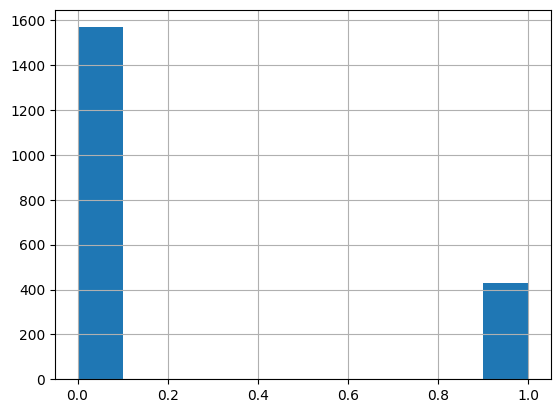

In [61]:
pd.Series(y_pred.squeeze()).hist()

In [62]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_train, y_pred)

0.6161021931743601